# PyTorch Workflow

Let's explore a an eample of an end-to-end workflow

In [1]:
what_were_covering = {
    1:"Data (prepare and load)",
    2:"build model",
    3:"fitting the model to data (training)",
    4:"making predictions and evaluation (inference)",
    5:"saving and loading a model",
    6:"putting it all together"
}

In [2]:
import torch
from torch import nn # nn contains all of PyTorch's building blocs for neural networks
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torchvision

device = torch.device('cuda')

torch.__version__

'1.9.1'

## 1. Data (preparing and loading)

Data can be almost anything.... in machine learning

* Excel spreadsheet
* CSV File
* JSON Files
* Images
* Audio
* Videos
* Text
* DNA

Machien learn is a game of two parts:
1. Get data into a numerical representation
2. Build a model to learn pattern in that numerical representation

To showcase this, let's create some *knowne* data using the linear regression formula

We'll use a linear regression formula to make a straight line with know parameters

In [3]:
# Create the known parameters

# y = bX + a
weight = 0.7 # b
bias = 0.3 # a

# Create data

start = 0.0
end = 5.0
step = 0.02
X = torch.arange(start, end ,step).unsqueeze(dim=1).to('cuda')
y = (weight * X + bias).to('cuda')

In [4]:
X[:5], y[:5]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800]], device='cuda:0'),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560]], device='cuda:0'))

In [5]:
len(X), len(y)

(250, 250)

So in AI what happens is that the Model checks the difference between the y predictions and the true y and changes its weights and biases according and finds the correct correlation between the 2

### Splitting data into trainings and test sets

- Training set - the training part
- Practising (checking the model out) - practise exam t
- test set - the final part

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split],y[:train_split]
X_test,y_test = X[train_split:], y[train_split:]

In [8]:
len(X_train),len(y_train), len(X_test), len(y_test)

(200, 200, 50, 50)

how might we better visualize our data?

This is where the data explorer's motto comes in!

"Visaulize, Visualize, Visualize!"

In [9]:
def plot_predictions(train_data=X_train,train_labels=y_train,test_data=X_test,test_labels=y_test,predictions=None):
    """
    Plots trainings data, test data and compares predictions
    """
    plt.figure(figsize=(10,7))
    
    # Plot trainings data in blue
    plt.scatter(train_data.cpu(),train_labels.cpu(), c='b', s=10, label='Trainings data')
    
    # Plot test data in green
    plt.scatter(test_data.cpu(), test_labels.cpu(), c='g', s=10, label='Testing data')
    
    if predictions is not None:
        # Plot the predictions
        plt.scatter(test_data.cpu(),predictions.cpu(),c='r', s=10, label='predictions')
    plt.legend(prop={"size":14})

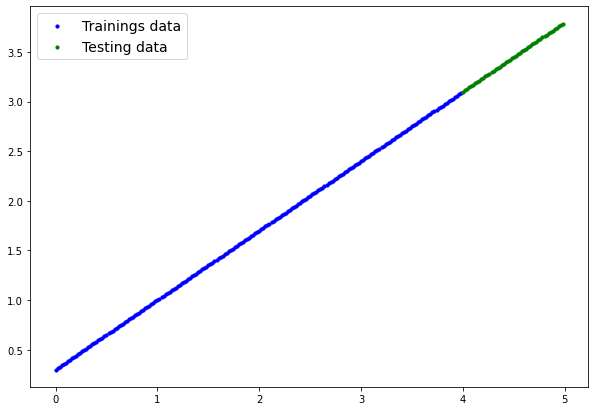

In [10]:
plot_predictions()

## 2. Build Model

Our first PyTorch Model!

What our model does:
* Start with random values (weights & bias)
* Look at training data and adjust the random values to better represent the actual weights and bias

They do this through
1. Gradient Descent
2. Backpropagation

In [11]:
# Create a linear regression model class

class LinearRegressionModel(nn.Module): # <- almost everythhing in pytorch inherits from nn.Module
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1,requires_grad=True,dtype=torch.float))
        self.bias = nn.Parameter(torch.randn(1,requires_grad=True,dtype=torch.float))
        
    def forward(self,X):
        return self.weights * X + self.bias

In [12]:
model = LinearRegressionModel().to('cuda')

### PyTorch model building essentials

* torch.nn - contains all of the buildings for computational graphs (another word for neural networks)
* torch.nn.Parameter - what parameters should our model try and learn, often a pytorch layer from torch.nn will set these for us
* torch.nn.Module - the base class for all neural network modules, if you subclass it, you should overwrite forward()
* torch.optim - this is where the optimizers in PyTorch live, they will help you with gradient descent
* def forward() - All nn.Module subclasses are required for you to overwrtite, forward(), this method defines what happens when data is passed to the model

### Checking the contents of our PyTorch Model

Now we've created a model, let's see what's inside...

SO we can check our model parameters or what's inside our model using '.parameters()'

In [13]:
torch.manual_seed(42)

# Create instance of the model
model_0 = LinearRegressionModel().to('cuda')

list(model_0.parameters()) # the values are the values they are becz we got random val

[Parameter containing:
 tensor([0.3367], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([0.1288], device='cuda:0', requires_grad=True)]

In [14]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367], device='cuda:0')),
             ('bias', tensor([0.1288], device='cuda:0'))])

### Making predictions using `torch.inference_mode()`

To check our models predictive poweerer, let's see how well it predictions  `y_test` based on `X_test`

When we pass data thhrough our moodel, it's going to run it through the forrward() mmeethod

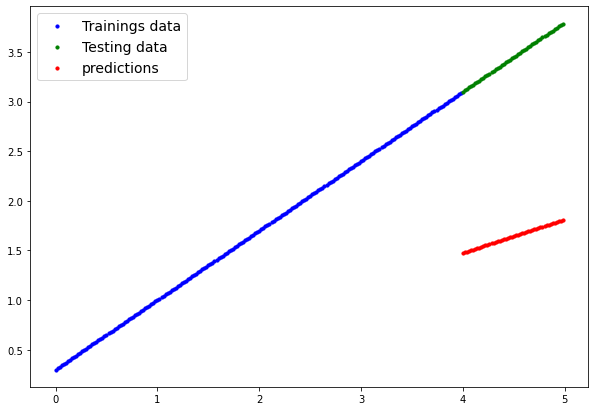

In [15]:
# predictions = inference
with torch.inference_mode():
    y_preds = model_0(X_test.to('cuda'))
plot_predictions(predictions=y_preds.cpu())

## 3. Train Model

The whole idea of training is for a model to move from *uknown* paamters to know parameters

or in other words from a poor representation of the data to a better representation of the data

One way to measure how badly the models predicions are is using a loss function

Loss functions also called "cost function" or "criterion"

Things we need to train : 

*Loss Fnction* is a function to measure how wrong the model's prediction is

*Optimizer* takes into accont the loss of a model and adjusts the model's parameters (weights and bias)

In [16]:
list(model_0.parameters()),model_0.state_dict()

([Parameter containing:
  tensor([0.3367], device='cuda:0', requires_grad=True),
  Parameter containing:
  tensor([0.1288], device='cuda:0', requires_grad=True)],
 OrderedDict([('weights', tensor([0.3367], device='cuda:0')),
              ('bias', tensor([0.1288], device='cuda:0'))]))

In [17]:
loss_fn = nn.L1Loss()

In [18]:
optimizer = torch.optim.SGD(params=model_0.parameters(),lr=0.01) 
# learning rate = possibily th emost important hyper parameter, it is a value that we set our selves, the learning rate is 
# smaller the learning rate the smaller the change done to parameters

### Building a training loop and testing loop

A couple things we need is:
1. Loop through the data
2. Forward pass (data moving through `forward()` function and make predictions
3. Calculate the loss (compare expected and predicted vals)
4. Loss backward - backward propagration, calculation works backwards throguh the network to calculate teh gradients of each the poarameters of our models with resepct to the loss (backpropagation)
5. optimizer step- use the optimizer to adjust the model's parameters (gradient decent)

In [19]:
from tqdm import tqdm
# the model gets to see the data once
epochs = 100

In [20]:
for epoch in tqdm(range(epochs)):
    # Set model to training model
    model_0.train() # turns on gradient tracking
    
    # Forward pass
    y_preds = model_0(X_train)
    
    # Calculaate the loss
    loss = loss_fn(y_preds,y_train)
    
    # Optimizer zero grad
    optimizer.zero_grad() # make sure that optimizer data doesnt add up, think as if its "C" so that it changes in every iteration
    
    # Back propagration
    loss.backward()
    
    # Gradient Descent
    optimizer.step()
    
    model_0.eval() # turns off gradient tracking

100%|█████████████████████████████████████| 100/100 [00:00<00:00, 2081.21it/s]


In [21]:
y_preds[:5],y_train[:5]

(tensor([[0.3099],
         [0.3241],
         [0.3382],
         [0.3523],
         [0.3665]], device='cuda:0', grad_fn=<SliceBackward>),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560]], device='cuda:0'))

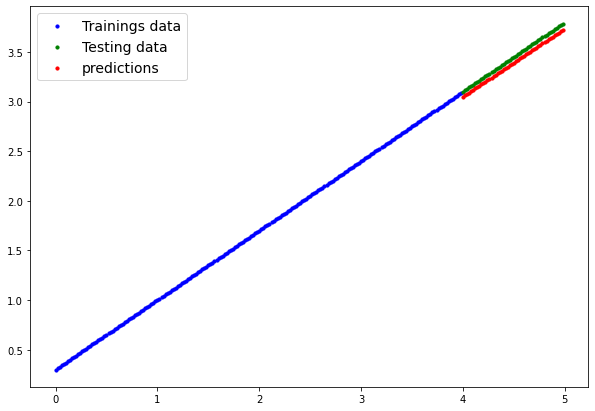

In [22]:
# predictions = inference
with torch.inference_mode():
    y_preds = model_0(X_test.to('cuda'))
plot_predictions(predictions=y_preds.cpu())